# 3.0 - Model Training and Evaluation - Team 34
German Credit Risk Prediction

This notebook demonstrates model training and evaluation using our pipeline.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Import our custom modules
from fase2.config import MODELS_DIR, PROCESSED_DATA_DIR, FIGURES_DIR, AUC_THRESHOLD
from fase2.modeling.train import (
    train_random_forest,
    train_logistic_regression,
    train_decision_tree,
    save_model
)
from fase2.modeling.predict import (
    load_model,
    evaluate_model,
    predict_proba
)
from fase2.plots import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importance
)

print("✓ Imports successful")

2025-10-26 22:39:21.831 | INFO     | fase2.config:<module>:11 - PROJ_ROOT path is: /Users/alejandrodiazvillagomez/Desktop/Proyecto/Fase2


✓ Imports successful


## Load Processed Data

In [2]:
X_train = pd.read_csv(PROCESSED_DATA_DIR / "X_train.csv")
X_test = pd.read_csv(PROCESSED_DATA_DIR / "X_test.csv")
y_train = pd.read_csv(PROCESSED_DATA_DIR / "y_train.csv").values.ravel()
y_test = pd.read_csv(PROCESSED_DATA_DIR / "y_test.csv").values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (551, 20)
Test set: (138, 20)


## Train Multiple Models

We'll train three models and compare their performance.

In [3]:
print("=== TRAINING MODELS ===\n")

# Train Random Forest
print("1️⃣ Random Forest...")
rf_model = train_random_forest(X_train, y_train)

# Train Logistic Regression
print("\n2️⃣ Logistic Regression...")
lr_model = train_logistic_regression(X_train, y_train)

# Train Decision Tree
print("\n3️⃣ Decision Tree...")
dt_model = train_decision_tree(X_train, y_train)

print("\n✓ All models trained!")

=== TRAINING MODELS ===

1️⃣ Random Forest...
2025-10-26 22:39:22.039 | INFO     | fase2.modeling.train:train_random_forest:38 - Training Random Forest Classifier...
2025-10-26 22:39:22.044 | INFO     | fase2.modeling.train:train_random_forest:50 - Parameter grid: {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
2025-10-26 22:39:22.044 | INFO     | fase2.modeling.train:train_random_forest:51 - Cross-validation folds: 5
Fitting 5 folds for each of 81 candidates, totalling 405 fits
2025-10-26 22:39:27.213 | SUCCESS  | fase2.modeling.train:train_random_forest:59 - ✓ Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
2025-10-26 22:39:27.214 | SUCCESS  | fase2.modeling.train:train_random_forest:60 - ✓ Best CV AUC score: 0.8003

2️⃣ Logistic Regression...
2025-10-26 22:39:27.214 | INFO     | fase2.modeling.train:train_logistic_regression:69 - Training Logistic Regr

## Evaluate Models on Test Set

In [4]:
models = {
    'Random Forest': rf_model,
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model
}

results = []

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Evaluating: {name}")
    print('='*60)
    
    metrics = evaluate_model(model, X_test, y_test)
    metrics['model_name'] = name
    results.append(metrics)


Evaluating: Random Forest
2025-10-26 22:39:27.348 | INFO     | fase2.modeling.predict:evaluate_model:64 - Evaluating model performance...
2025-10-26 22:39:27.348 | INFO     | fase2.modeling.predict:predict:41 - Making predictions on 138 samples...
2025-10-26 22:39:27.353 | SUCCESS  | fase2.modeling.predict:predict:43 - ✓ Predictions complete
2025-10-26 22:39:27.353 | INFO     | fase2.modeling.predict:predict_proba:50 - Computing prediction probabilities...
2025-10-26 22:39:27.355 | SUCCESS  | fase2.modeling.predict:predict_proba:52 - ✓ Probabilities computed
2025-10-26 22:39:27.360 | SUCCESS  | fase2.modeling.predict:evaluate_model:82 - ✓ Model evaluation complete
2025-10-26 22:39:27.360 | INFO     | fase2.modeling.predict:evaluate_model:83 -   Accuracy:  0.7681
2025-10-26 22:39:27.360 | INFO     | fase2.modeling.predict:evaluate_model:84 -   Precision: 0.7851
2025-10-26 22:39:27.360 | INFO     | fase2.modeling.predict:evaluate_model:85 -   Recall:    0.9406
2025-10-26 22:39:27.360 | 

## Compare Model Performance


=== MODEL COMPARISON ===
         model_name  accuracy  precision   recall  f1_score  auc_roc
Logistic Regression  0.739130   0.748092 0.970297  0.844828 0.831416
      Random Forest  0.768116   0.785124 0.940594  0.855856 0.827402
      Decision Tree  0.768116   0.828571 0.861386  0.844660 0.780037


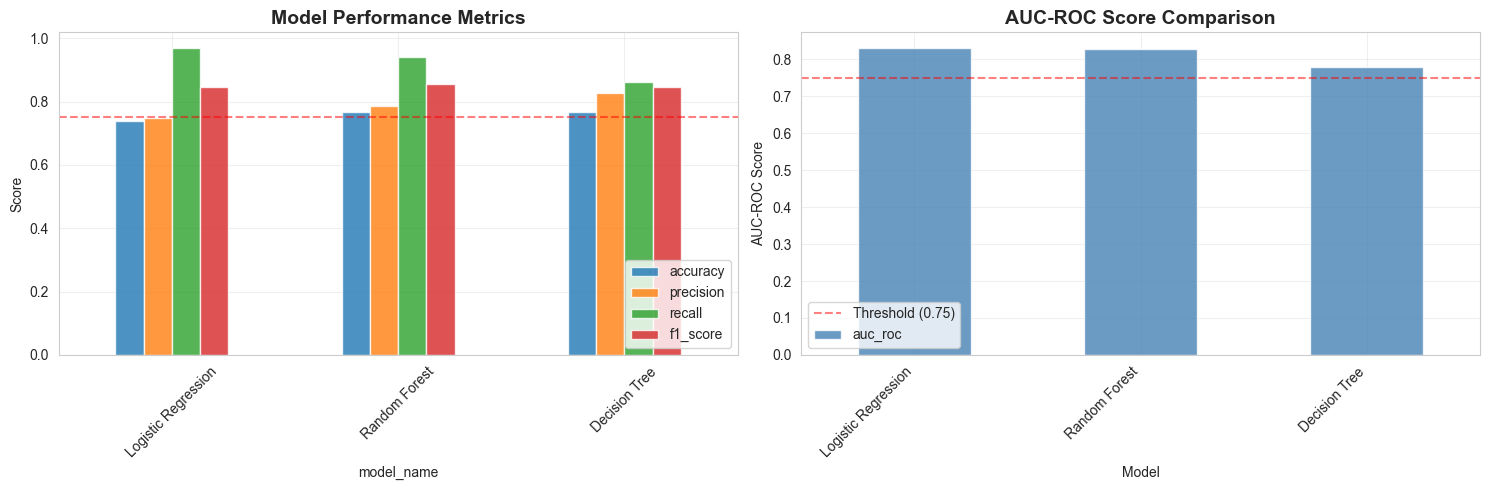

In [5]:
# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df = results_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']]
results_df = results_df.sort_values('auc_roc', ascending=False)

print("\n=== MODEL COMPARISON ===")
print(results_df.to_string(index=False))

# %%
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
results_df.set_index('model_name')[metrics_to_plot].plot(
    kind='bar', ax=axes[0], alpha=0.8, rot=45
)
axes[0].set_title('Model Performance Metrics', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].axhline(y=0.75, color='red', linestyle='--', alpha=0.5, label='Target (0.75)')
axes[0].grid(True, alpha=0.3)

# AUC-ROC comparison
results_df.plot(x='model_name', y='auc_roc', kind='bar', ax=axes[1], 
                color='steelblue', alpha=0.8, legend=False)
axes[1].set_title('AUC-ROC Score Comparison', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('AUC-ROC Score')
axes[1].axhline(y=AUC_THRESHOLD, color='red', linestyle='--', 
               alpha=0.5, label=f'Threshold ({AUC_THRESHOLD})')
axes[1].legend()
axes[1].set_xticklabels(results_df['model_name'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Best Model Analysis

In [6]:
# Select best model
best_model_name = results_df.iloc[0]['model_name']
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"AUC-ROC: {results_df.iloc[0]['auc_roc']:.4f}")


🏆 Best Model: Logistic Regression
AUC-ROC: 0.8314


### Confusion Matrix

In [7]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, best_model_name, FIGURES_DIR)
plt.show()

2025-10-26 22:39:27.752 | INFO     | fase2.plots:plot_confusion_matrix:73 - Plotting confusion matrix for Logistic Regression...
2025-10-26 22:39:27.864 | SUCCESS  | fase2.plots:plot_confusion_matrix:115 - ✓ Confusion matrix saved to: /Users/alejandrodiazvillagomez/Desktop/Proyecto/Fase2/reports/figures/confusion_matrix_logistic_regression.png


### ROC Curve

In [8]:
y_proba = predict_proba(best_model, X_test)

if y_proba is not None:
    plot_roc_curve(y_test, y_proba, best_model_name, FIGURES_DIR)
    plt.show()

2025-10-26 22:39:27.868 | INFO     | fase2.modeling.predict:predict_proba:50 - Computing prediction probabilities...
2025-10-26 22:39:27.868 | SUCCESS  | fase2.modeling.predict:predict_proba:52 - ✓ Probabilities computed
2025-10-26 22:39:27.868 | INFO     | fase2.plots:plot_roc_curve:121 - Plotting ROC curve for Logistic Regression...
2025-10-26 22:39:28.008 | SUCCESS  | fase2.plots:plot_roc_curve:173 - ✓ ROC curve saved to: /Users/alejandrodiazvillagomez/Desktop/Proyecto/Fase2/reports/figures/roc_curve_logistic_regression.png


### Feature Importance

In [9]:
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n=== TOP 10 FEATURES ===")
    print(importance_df.head(10).to_string(index=False))
    
    plot_feature_importance(importance_df, best_model_name, top_n=15, save_path=FIGURES_DIR)
    plt.show()

### Classification Report

In [10]:
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, 
                           target_names=['Bad Credit (0)', 'Good Credit (1)']))


=== CLASSIFICATION REPORT ===
                 precision    recall  f1-score   support

 Bad Credit (0)       0.57      0.11      0.18        37
Good Credit (1)       0.75      0.97      0.84       101

       accuracy                           0.74       138
      macro avg       0.66      0.54      0.51       138
   weighted avg       0.70      0.74      0.67       138



## Save Best Model

The best model has been saved to `models/` directory.

In [11]:
# Model is already saved by the training script
print(f"✓ Best model saved: {best_model_name}")
print(f"  Location: {MODELS_DIR / best_model_name.lower().replace(' ', '_')}.pkl")
print("✓ Model training and evaluation complete! 🎉")

✓ Best model saved: Logistic Regression
  Location: /Users/alejandrodiazvillagomez/Desktop/Proyecto/Fase2/models/logistic_regression.pkl
✓ Model training and evaluation complete! 🎉
